### SDOF Base Neural Network

In [19]:
import torch
import os
from data import get_dataset, get_rawdata
import matplotlib.pyplot as plt
from nn_base import BaseNN
from ecnn import ECNN
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp
import numpy as np

### Constants

In [20]:
args_dict = {
    'seed': 0,
    'input_dim': 2, 
    'hidden_dim': 200,
    'learn_rate': 1e-3,
    'num_steps': 2000,
    'print_every': 200,
    'name': 'dynamics'
}
class ObjectView(object):
    def __init__(self, d):
        self.__dict__ = d
args = ObjectView(args_dict)


### Raw Dataset

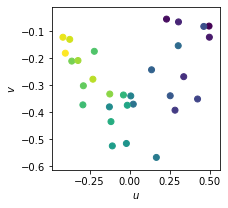

In [21]:
data = get_dataset()
# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white')

u, v, dudt, dvdt, t = get_rawdata()
plt.scatter(u,v,c=t)
plt.xlabel("$u$")
plt.ylabel("$v$")
plt.show()

### Construct Models

In [22]:
def get_model(args, baseline):
    output_dim = 2
    nn_model = BaseNN(args.input_dim, args.hidden_dim, output_dim)
    model = ECNN( args.input_dim, nn_model, baseline )
    naming = '-baseline' if baseline else ''
    path = 'dynamics{}.tar'.format(naming)
    model.load_state_dict(torch.load(path))
    return nn_model

### Integrate Model

In [23]:
def integrate_model(model, t_span, uv0, **kwargs):
    def fun(t, uv_in):
        uv = torch.tensor( uv_in, requires_grad=True, dtype=torch.float32 ).view(1,2)
        duv = model.forward(uv).data.numpy().reshape(-1)
        return duv
    return solve_ivp(fun=fun, t_span=t_span, y0=uv0, **kwargs)

### Analysis

In [24]:
base_model = get_model(args, True)
ecnn_model = get_model(args, False)
t_span = [0,30]
uv0 = np.array([1., 0.])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 2000), 'rtol': 1e-12}
base_ivp = integrate_model( base_model, t_span, uv0, **kwargs )
ecnn_ivp = integrate_model( ecnn_model, t_span, uv0, **kwargs )

### Plot results

Text(0.5, 1.0, 'Base NN')

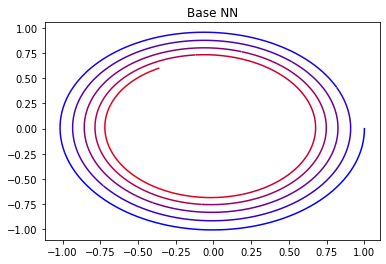

In [25]:
fig = plt.figure()
# print(base_ivp)
LINE_SEGMENTS = 10
for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color)
plt.title('Base NN')

Text(0.5, 1.0, 'ECNN')

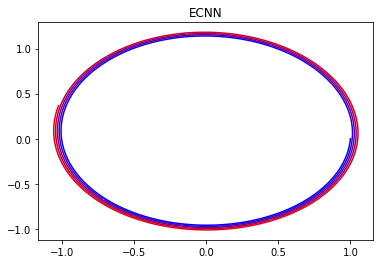

In [26]:
fig = plt.figure()
# print(base_ivp)
LINE_SEGMENTS = 10
for i, l in enumerate(np.split(ecnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color)
plt.title('ECNN')